/hpc/group/goldsteinlab/envs/cell2loc_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1755: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(
/hpc/group/goldsteinlab/envs/cell2loc_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1755: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(



Concatenating final list of AnnData objects ...


/hpc/group/goldsteinlab/envs/cell2loc_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1755: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(


Done final concatenation!
Final shape: (170387, 38550)

Virus -> # matched genes:
HHV4 -> 94
HHV6 -> 191
SARS-CoV2 -> 22

Finished building df_grouped:
                                                        HHV4      HHV6  \
COVID_hyposmic2_combined                            0.000000  0.000000   
HHV6a_b_EBV_pos_ctrl                                0.117454  0.000002   
/hpc/group/goldsteinlab/vmd13/241224_COVID_EBV_...  0.000000  0.000000   
/hpc/group/goldsteinlab/vmd13/241224_COVID_EBV_...  0.000000  0.000000   
/hpc/group/goldsteinlab/vmd13/241224_COVID_EBV_...  0.000000  0.000000   
/hpc/group/goldsteinlab/vmd13/241224_COVID_EBV_...  0.000000  0.000000   
/hpc/group/goldsteinlab/vmd13/241224_COVID_EBV_...  0.000000  0.000000   
/hpc/group/goldsteinlab/vmd13/241224_COVID_EBV_...  0.000000  0.000000   
/hpc/group/goldsteinlab/vmd13/241224_COVID_EBV_...  0.000000  0.000000   
/hpc/group/goldsteinlab/vmd13/241224_COVID_EBV_...  0.000000  0.000000   
/hpc/group/goldsteinlab/vmd13/2412

/tmp/ipykernel_198947/142697416.py:270: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


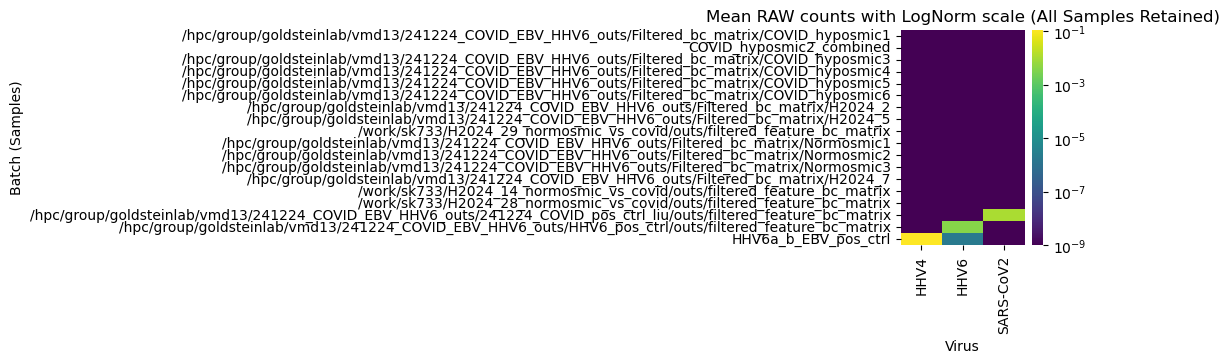

In [1]:
#!/usr/bin/env python

import os
import scanpy as sc
import numpy as np
import pandas as pd
from anndata import AnnData
from scipy.sparse import issparse

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm


##############################################################################
# A) DEFINE SAMPLE DIRECTORIES AND READ THEM AS ANNDATA
##############################################################################

# 1) Define groups of sample directories to combine under a single label
groups_to_combine = {
    "COVID_hyposmic2_combined": [
        "/hpc/group/goldsteinlab/vmd13/241224_COVID_EBV_HHV6_outs/Filtered_bc_matrix/COVID_hyposmic2",
        "/hpc/group/goldsteinlab/vmd13/241224_COVID_EBV_HHV6_outs/Filtered_bc_matrix/COVID_hyposmic2_portion2",
    ],
    "HHV6a_b_EBV_pos_ctrl": [
        "/hpc/group/goldsteinlab/vmd13/241224_COVID_EBV_HHV6_outs/HHV6a_EBV_pos_ctrl/outs/filtered_feature_bc_matrix",
        "/hpc/group/goldsteinlab/vmd13/241224_COVID_EBV_HHV6_outs/HHV6b_EBV_pos_ctrl/outs/filtered_feature_bc_matrix",
    ],
}

# 2) Define other sample dirs that remain single / not combined
other_sample_dirs = [
    "/hpc/group/goldsteinlab/vmd13/241224_COVID_EBV_HHV6_outs/Filtered_bc_matrix/COVID_hyposmic1",
    "/hpc/group/goldsteinlab/vmd13/241224_COVID_EBV_HHV6_outs/Filtered_bc_matrix/COVID_hyposmic3",
    "/hpc/group/goldsteinlab/vmd13/241224_COVID_EBV_HHV6_outs/Filtered_bc_matrix/COVID_hyposmic4",
    "/hpc/group/goldsteinlab/vmd13/241224_COVID_EBV_HHV6_outs/Filtered_bc_matrix/COVID_hyposmic5",
    "/hpc/group/goldsteinlab/vmd13/241224_COVID_EBV_HHV6_outs/Filtered_bc_matrix/COVID_hyposmic6",
    "/hpc/group/goldsteinlab/vmd13/241224_COVID_EBV_HHV6_outs/Filtered_bc_matrix/H2024_2",
    "/hpc/group/goldsteinlab/vmd13/241224_COVID_EBV_HHV6_outs/Filtered_bc_matrix/H2024_5",
    "/hpc/group/goldsteinlab/vmd13/241224_COVID_EBV_HHV6_outs/Filtered_bc_matrix/H2024_7",
    "/hpc/group/goldsteinlab/vmd13/241224_COVID_EBV_HHV6_outs/Filtered_bc_matrix/Normosmic1",
    "/hpc/group/goldsteinlab/vmd13/241224_COVID_EBV_HHV6_outs/Filtered_bc_matrix/Normosmic2",
    "/hpc/group/goldsteinlab/vmd13/241224_COVID_EBV_HHV6_outs/Filtered_bc_matrix/Normosmic3",
    "/work/sk733/H2024_14_normosmic_vs_covid/outs/filtered_feature_bc_matrix",
    "/work/sk733/H2024_28_normosmic_vs_covid/outs/filtered_feature_bc_matrix",
    "/work/sk733/H2024_29_normosmic_vs_covid/outs/filtered_feature_bc_matrix",
    "/hpc/group/goldsteinlab/vmd13/241224_COVID_EBV_HHV6_outs/241224_COVID_pos_ctrl_liu/outs/filtered_feature_bc_matrix",
    "/hpc/group/goldsteinlab/vmd13/241224_COVID_EBV_HHV6_outs/HHV6_pos_ctrl/outs/filtered_feature_bc_matrix",
]

def read_10x_or_none(path):
    """Helper to read a 10x directory safely; returns None if there's an error or it's empty."""
    if not os.path.isdir(path):
        print(f"WARNING: Directory not found or inaccessible: {path}")
        return None
    try:
        ad = sc.read_10x_mtx(path, var_names="gene_ids", cache=True)
        if ad.n_obs == 0 or ad.n_vars == 0:
            print(f"Skipping empty dataset: {path}")
            return None
        # Make var_names and obs_names unique
        ad.var_names_make_unique()
        ad.obs_names_make_unique()
        # If there's a "gene_symbols" col, rename to "gene_symbol"
        if "gene_symbols" in ad.var.columns:
            ad.var.rename(columns={"gene_symbols": "gene_symbol"}, inplace=True)
        if "gene_symbol" not in ad.var.columns:
            ad.var["gene_symbol"] = ad.var.index.astype(str)
        # Also create a "gene_id" column
        ad.var["gene_id"] = ad.var.index.astype(str)
        return ad
    except Exception as e:
        print(f"ERROR reading sample {path}: {e}")
        return None

# 3) Read and combine data
adatas_combined = []
batch_names = []

# --- 3A) Combine multi-directory groups ---
for combined_name, dir_list in groups_to_combine.items():
    tmp_adatas = []
    for d in dir_list:
        ad = read_10x_or_none(d)
        if ad is not None:
            tmp_adatas.append(ad)
    if len(tmp_adatas) == 0:
        print(f"No valid data for group {combined_name}; skipping.")
        continue
    if len(tmp_adatas) == 1:
        final_ad = tmp_adatas[0]
    else:
        # Old .concatenate approach
        final_ad = tmp_adatas[0].concatenate(
            *tmp_adatas[1:],
            join="outer",
            batch_key=None
        )
    adatas_combined.append(final_ad)
    batch_names.append(combined_name)

# --- 3B) Handle single directories ---
for d in other_sample_dirs:
    ad = read_10x_or_none(d)
    if ad is not None:
        adatas_combined.append(ad)
        batch_names.append(d)

# Final big concatenation
if len(adatas_combined) == 0:
    raise ValueError("No valid AnnData objects found; nothing to concatenate.")

print("\nConcatenating final list of AnnData objects ...")
adata_combined = adatas_combined[0].concatenate(
    *adatas_combined[1:],
    join="outer",
    batch_key="batch",
    batch_categories=batch_names
)
print("Done final concatenation!")
print("Final shape:", adata_combined.shape)

# Store raw counts in a separate layer
adata_combined.layers["counts"] = adata_combined.X.copy()

##############################################################################
# B) UNIFY GENE FIELDS AND DEFINE VIRUSES
##############################################################################

# Ensure we have a "gene_id_unified" and "gene_symbol_unified"
if "gene_id" in adata_combined.var.columns:
    adata_combined.var["gene_id_unified"] = adata_combined.var["gene_id"].astype(str)
else:
    adata_combined.var["gene_id_unified"] = adata_combined.var_names.astype(str)

if "gene_symbol" in adata_combined.var.columns:
    adata_combined.var["gene_symbol_unified"] = adata_combined.var["gene_symbol"].astype(str)
else:
    adata_combined.var["gene_symbol_unified"] = adata_combined.var_names.astype(str)

# Example dictionary combining omicron/delta into SARS-CoV2
my_virus_search = {
    "HHV4": {
        "gene_id_pattern": ["HHV4"],
        "gene_symbol_pattern": ["HHV4"]
    },
    "HHV6": {
        "gene_id_pattern": ["gene-HHV6"],
        "gene_symbol_pattern": ["gene-HHV6"]
    },
    # Combine omicron_ and delta_ into one label: "SARS-CoV2"
    "SARS-CoV2": {
        "gene_id_pattern": ["omicron_", "delta_"],
        "gene_symbol_pattern": ["omicron_", "delta_"]
    }
}

virus2genes = {}

for virus_name, patdict in my_virus_search.items():
    gene_id_pats = patdict["gene_id_pattern"]
    gene_sym_pats= patdict["gene_symbol_pattern"]
    
    mask_union = pd.Series([False]*adata_combined.n_vars, index=adata_combined.var_names)
    
    for pat in gene_id_pats:
        mask_id = adata_combined.var["gene_id_unified"].str.contains(pat, case=False, na=False)
        mask_union = mask_union | mask_id
        
    for pat in gene_sym_pats:
        mask_sym = adata_combined.var["gene_symbol_unified"].str.contains(pat, case=False, na=False)
        mask_union = mask_union | mask_sym

    found_idx  = np.where(mask_union)[0]
    found_vars = adata_combined.var_names[found_idx]
    virus2genes[virus_name] = list(found_vars)

print("\nVirus -> # matched genes:")
for v in virus2genes:
    print(f"{v} -> {len(virus2genes[v])}")

##############################################################################
# C) BUILD A (BATCH × VIRUS) TABLE OF MEAN RAW COUNTS
##############################################################################

all_batches = adata_combined.obs["batch"].cat.categories  # from .concatenate()
virus_names = list(virus2genes.keys())

df_grouped = pd.DataFrame(index=all_batches, columns=virus_names, dtype=float)

for b in all_batches:
    batch_mask = (adata_combined.obs["batch"] == b)
    adata_batch = adata_combined[batch_mask, :]
    
    X_batch = adata_batch.layers["counts"]  # raw counts
    if issparse(X_batch):
        X_batch = X_batch.A  # convert to dense array if needed
    
    # Map var_name -> column index
    var_index_map = {gn: i for i, gn in enumerate(adata_batch.var_names)}
    
    for virus in virus_names:
        gene_list = virus2genes[virus]
        # convert gene names to column indices, skipping any not found
        cols_idx = [var_index_map[g] for g in gene_list if g in var_index_map]
        if len(cols_idx) == 0:
            df_grouped.loc[b, virus] = 0.0
            continue
        
        sub_mat = X_batch[:, cols_idx]  # shape (#cells × #virus_genes)
        mean_raw = sub_mat.mean()
        df_grouped.loc[b, virus] = mean_raw

print("\nFinished building df_grouped:")
print(df_grouped)


##############################################################################
# D) REORDER & PLOT WITH LogNorm (NO SAMPLE REMOVAL)
##############################################################################

# Example custom row order
custom_row_order = [
    '/hpc/group/goldsteinlab/vmd13/241224_COVID_EBV_HHV6_outs/Filtered_bc_matrix/COVID_hyposmic1',
    'COVID_hyposmic2_combined',
    '/hpc/group/goldsteinlab/vmd13/241224_COVID_EBV_HHV6_outs/Filtered_bc_matrix/COVID_hyposmic3',
    '/hpc/group/goldsteinlab/vmd13/241224_COVID_EBV_HHV6_outs/Filtered_bc_matrix/COVID_hyposmic4',
    '/hpc/group/goldsteinlab/vmd13/241224_COVID_EBV_HHV6_outs/Filtered_bc_matrix/COVID_hyposmic5',
    '/hpc/group/goldsteinlab/vmd13/241224_COVID_EBV_HHV6_outs/Filtered_bc_matrix/COVID_hyposmic6',
    '/hpc/group/goldsteinlab/vmd13/241224_COVID_EBV_HHV6_outs/Filtered_bc_matrix/H2024_2',
    '/hpc/group/goldsteinlab/vmd13/241224_COVID_EBV_HHV6_outs/Filtered_bc_matrix/H2024_5',
    '/work/sk733/H2024_29_normosmic_vs_covid/outs/filtered_feature_bc_matrix',
    '/hpc/group/goldsteinlab/vmd13/241224_COVID_EBV_HHV6_outs/Filtered_bc_matrix/Normosmic1',
    '/hpc/group/goldsteinlab/vmd13/241224_COVID_EBV_HHV6_outs/Filtered_bc_matrix/Normosmic2',
    '/hpc/group/goldsteinlab/vmd13/241224_COVID_EBV_HHV6_outs/Filtered_bc_matrix/Normosmic3',
    '/hpc/group/goldsteinlab/vmd13/241224_COVID_EBV_HHV6_outs/Filtered_bc_matrix/H2024_7',
    '/work/sk733/H2024_14_normosmic_vs_covid/outs/filtered_feature_bc_matrix',
    '/work/sk733/H2024_28_normosmic_vs_covid/outs/filtered_feature_bc_matrix',
    '/hpc/group/goldsteinlab/vmd13/241224_COVID_EBV_HHV6_outs/241224_COVID_pos_ctrl_liu/outs/filtered_feature_bc_matrix',
    '/hpc/group/goldsteinlab/vmd13/241224_COVID_EBV_HHV6_outs/HHV6_pos_ctrl/outs/filtered_feature_bc_matrix',
    'HHV6a_b_EBV_pos_ctrl'
]

# Define the custom column order (virus order)
custom_column_order = ["HHV4", "HHV6", "SARS-CoV2"]

# Subset df_grouped based on the order defined:
# (Note: any labels in custom_row_order that do NOT appear in df_grouped.index will cause a KeyError,
#  so you might want to filter them out if some samples were not found/read)
row_order_valid = [s for s in custom_row_order if s in df_grouped.index]
df_custom = df_grouped.loc[row_order_valid, custom_column_order]

# Replace zeros with a small value for LogNorm
df_custom_no0 = df_custom.replace(0, 1e-9)

vmin = 1e-9
vmax = df_custom_no0.values.max()  # or set your own upper limit

plt.figure(figsize=(0.5 + 0.5 * df_custom_no0.shape[1], 1 + 0.1 * df_custom_no0.shape[0]))
sns.heatmap(
    df_custom_no0,
    cmap="viridis",
    norm=LogNorm(vmin=vmin, vmax=vmax),
    xticklabels=True,
    yticklabels=True
)
plt.xlabel("Virus")
plt.ylabel("Batch (Samples)")
plt.title("Mean RAW counts with LogNorm scale (All Samples Retained)")
plt.tight_layout()

# Example: save to file
plt.savefig("/hpc/group/goldsteinlab/vmd13/250225_simple_heatmap_all_samples.svg", bbox_inches="tight")

plt.show()


/hpc/group/goldsteinlab/envs/cell2loc_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1755: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(
/hpc/group/goldsteinlab/envs/cell2loc_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1755: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(



Concatenating final list of AnnData objects ...


/hpc/group/goldsteinlab/envs/cell2loc_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1755: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(


Done final concatenation!
Final shape: (170387, 38550)
Virus HHV4 -> 94 matched genes
Virus HHV6 -> 191 matched genes
Virus SARS-CoV2 -> 22 matched genes

Finished building df_grouped:
                                                        HHV4      HHV6  \
COVID_hyposmic2_combined                            0.000000  0.000000   
HHV6a_b_EBV_pos_ctrl                                0.117454  0.000002   
/hpc/group/goldsteinlab/vmd13/241224_COVID_EBV_...  0.000000  0.000000   
/hpc/group/goldsteinlab/vmd13/241224_COVID_EBV_...  0.000000  0.000000   
/hpc/group/goldsteinlab/vmd13/241224_COVID_EBV_...  0.000000  0.000000   
/hpc/group/goldsteinlab/vmd13/241224_COVID_EBV_...  0.000000  0.000000   
/hpc/group/goldsteinlab/vmd13/241224_COVID_EBV_...  0.000000  0.000000   
/hpc/group/goldsteinlab/vmd13/241224_COVID_EBV_...  0.000000  0.000000   
/hpc/group/goldsteinlab/vmd13/241224_COVID_EBV_...  0.000000  0.000000   
/hpc/group/goldsteinlab/vmd13/241224_COVID_EBV_...  0.000000  0.000000   
/

/tmp/ipykernel_2539389/1541479223.py:245: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


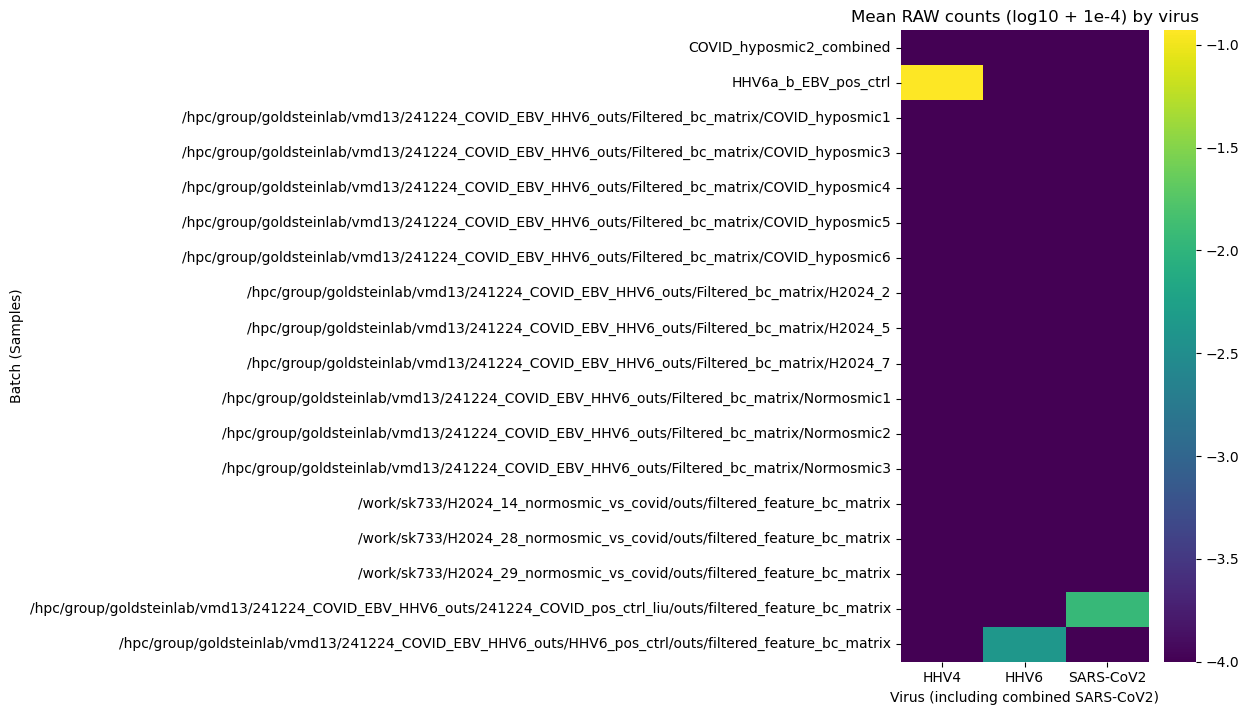

In [1]:
import os
import scanpy as sc
import numpy as np
import pandas as pd
from anndata import AnnData
from scipy.sparse import issparse
import seaborn as sns
import matplotlib.pyplot as plt

##############################################################################
# A) COMBINE SAMPLES
##############################################################################

# 1) Define groups of sample directories to combine
groups_to_combine = {
    "COVID_hyposmic2_combined": [
        "/hpc/group/goldsteinlab/vmd13/241224_COVID_EBV_HHV6_outs/Filtered_bc_matrix/COVID_hyposmic2",
        "/hpc/group/goldsteinlab/vmd13/241224_COVID_EBV_HHV6_outs/Filtered_bc_matrix/COVID_hyposmic2_portion2",
    ],
    "HHV6a_b_EBV_pos_ctrl": [
        "/hpc/group/goldsteinlab/vmd13/241224_COVID_EBV_HHV6_outs/HHV6a_EBV_pos_ctrl/outs/filtered_feature_bc_matrix",
        "/hpc/group/goldsteinlab/vmd13/241224_COVID_EBV_HHV6_outs/HHV6b_EBV_pos_ctrl/outs/filtered_feature_bc_matrix",
    ],
}

# 2) Define other sample dirs that remain single / not combined
other_sample_dirs = [
    "/hpc/group/goldsteinlab/vmd13/241224_COVID_EBV_HHV6_outs/Filtered_bc_matrix/COVID_hyposmic1",
    "/hpc/group/goldsteinlab/vmd13/241224_COVID_EBV_HHV6_outs/Filtered_bc_matrix/COVID_hyposmic3",
    "/hpc/group/goldsteinlab/vmd13/241224_COVID_EBV_HHV6_outs/Filtered_bc_matrix/COVID_hyposmic4",
    "/hpc/group/goldsteinlab/vmd13/241224_COVID_EBV_HHV6_outs/Filtered_bc_matrix/COVID_hyposmic5",
    "/hpc/group/goldsteinlab/vmd13/241224_COVID_EBV_HHV6_outs/Filtered_bc_matrix/COVID_hyposmic6",
    "/hpc/group/goldsteinlab/vmd13/241224_COVID_EBV_HHV6_outs/Filtered_bc_matrix/H2024_2",
    "/hpc/group/goldsteinlab/vmd13/241224_COVID_EBV_HHV6_outs/Filtered_bc_matrix/H2024_5",
    "/hpc/group/goldsteinlab/vmd13/241224_COVID_EBV_HHV6_outs/Filtered_bc_matrix/H2024_7",
    "/hpc/group/goldsteinlab/vmd13/241224_COVID_EBV_HHV6_outs/Filtered_bc_matrix/Normosmic1",
    "/hpc/group/goldsteinlab/vmd13/241224_COVID_EBV_HHV6_outs/Filtered_bc_matrix/Normosmic2",
    "/hpc/group/goldsteinlab/vmd13/241224_COVID_EBV_HHV6_outs/Filtered_bc_matrix/Normosmic3",
    "/work/sk733/H2024_14_normosmic_vs_covid/outs/filtered_feature_bc_matrix",
    "/work/sk733/H2024_28_normosmic_vs_covid/outs/filtered_feature_bc_matrix",
    "/work/sk733/H2024_29_normosmic_vs_covid/outs/filtered_feature_bc_matrix",
    "/hpc/group/goldsteinlab/vmd13/241224_COVID_EBV_HHV6_outs/241224_COVID_pos_ctrl_liu/outs/filtered_feature_bc_matrix",
    "/hpc/group/goldsteinlab/vmd13/241224_COVID_EBV_HHV6_outs/HHV6_pos_ctrl/outs/filtered_feature_bc_matrix",
]

def read_10x_or_none(path):
    """Helper to read a 10x directory safely; returns None if there's an error or it's empty."""
    if not os.path.isdir(path):
        print(f"WARNING: Directory not found or inaccessible: {path}")
        return None
    try:
        ad = sc.read_10x_mtx(path, var_names="gene_ids", cache=True)
        if ad.n_obs == 0 or ad.n_vars == 0:
            print(f"Skipping empty dataset: {path}")
            return None
        # Make var_names and obs_names unique
        ad.var_names_make_unique()
        ad.obs_names_make_unique()
        # If there's a "gene_symbols" col, rename to "gene_symbol"
        if "gene_symbols" in ad.var.columns:
            ad.var.rename(columns={"gene_symbols": "gene_symbol"}, inplace=True)
        if "gene_symbol" not in ad.var.columns:
            ad.var["gene_symbol"] = ad.var.index.astype(str)
        # Also create a "gene_id" column
        ad.var["gene_id"] = ad.var.index.astype(str)
        return ad
    except Exception as e:
        print(f"ERROR reading sample {path}: {e}")
        return None

# 3) Build list of final AnnData objects + batch labels
adatas_combined = []
batch_names = []

# --- 3A) Combine groups of directories ---
for combined_name, dir_list in groups_to_combine.items():
    tmp_adatas = []
    for d in dir_list:
        ad = read_10x_or_none(d)
        if ad is not None:
            tmp_adatas.append(ad)
    if len(tmp_adatas) == 0:
        print(f"No valid data for group {combined_name}; skipping.")
        continue
    # If only one directory was valid, we can just use that
    if len(tmp_adatas) == 1:
        final_ad = tmp_adatas[0]
    else:
        # Use new anndata.concat (recommended) or old .concatenate
        final_ad = tmp_adatas[0].concatenate(
            *tmp_adatas[1:], 
            join="outer", 
            batch_key=None  # or some other approach
        )
        # The old .concatenate might rename var columns. 
        # We'll unify gene_id/gene_symbol again, if necessary.
        # ...
        # Also note final_ad will have X from the concatenation. 
        # For clarity, you might want anndata.concat instead:
        # final_ad = anndata.concat(tmp_adatas, join="outer", label="tmp_batch", keys=None)
        
        # If needed, unify final_ad.var["gene_id"], final_ad.var["gene_symbol"]
        # ...
    adatas_combined.append(final_ad)
    batch_names.append(combined_name)

# --- 3B) Handle other single directories ---
for d in other_sample_dirs:
    ad = read_10x_or_none(d)
    if ad is not None:
        adatas_combined.append(ad)
        batch_names.append(d)

# 4) Final big concatenation of all combined + single samples
if len(adatas_combined) == 0:
    raise ValueError("No valid AnnData objects found; nothing to concatenate.")

print("\nConcatenating final list of AnnData objects ...")
adata_combined = adatas_combined[0].concatenate(
    *adatas_combined[1:],
    join="outer",
    batch_key="batch",
    batch_categories=batch_names
)
print("Done final concatenation!")
print("Final shape:", adata_combined.shape)

# Store raw counts layer
adata_combined.layers["counts"] = adata_combined.X.copy()

# Unify columns gene_id_unified / gene_symbol_unified
# (Same logic as you used before)
if "gene_id" in adata_combined.var.columns:
    adata_combined.var["gene_id_unified"] = adata_combined.var["gene_id"].astype(str)
else:
    # fallback ...
    adata_combined.var["gene_id_unified"] = adata_combined.var_names.astype(str)

if "gene_symbol" in adata_combined.var.columns:
    adata_combined.var["gene_symbol_unified"] = adata_combined.var["gene_symbol"].astype(str)
else:
    adata_combined.var["gene_symbol_unified"] = adata_combined.var_names.astype(str)

##############################################################################
# B) DEFINE "SARS-CoV2" AS OMICRON + DELTA
##############################################################################
# For your virus dictionary, combine multiple patterns into a single virus label.

my_virus_search = {
    "HHV4": {
        "gene_id_pattern": ["HHV4"],      # single pattern
        "gene_symbol_pattern": ["HHV4"]
    },
    "HHV6": {
        "gene_id_pattern": ["gene-HHV6"], # single pattern
        "gene_symbol_pattern": ["gene-HHV6"]
    },
    # Combine omicron_ and delta_ into one label: "SARS-CoV2"
    "SARS-CoV2": {
        "gene_id_pattern": ["omicron_", "delta_"],   # multiple substrings
        "gene_symbol_pattern": ["omicron_", "delta_"]
    },
    # Add other viruses if needed ...
}

# Now we’ll search for each virus by scanning for ANY of the patterns in that list.
virus2genes = {}

for virus_name, patdict in my_virus_search.items():
    gene_id_pats = patdict["gene_id_pattern"]
    gene_sym_pats= patdict["gene_symbol_pattern"]
    
    # build up a combined mask from multiple patterns
    mask_union = pd.Series([False]*adata_combined.n_vars, index=adata_combined.var_names)
    
    for pat in gene_id_pats:
        mask_id = adata_combined.var["gene_id_unified"].str.contains(pat, case=False, na=False)
        mask_union = mask_union | mask_id
        
    for pat in gene_sym_pats:
        mask_sym = adata_combined.var["gene_symbol_unified"].str.contains(pat, case=False, na=False)
        mask_union = mask_union | mask_sym

    found_idx  = np.where(mask_union)[0]
    found_vars = adata_combined.var_names[found_idx]
    virus2genes[virus_name] = list(found_vars)

for v in virus2genes:
    print(f"Virus {v} -> {len(virus2genes[v])} matched genes")

##############################################################################
# C) BUILD A (BATCH × VIRUS) TABLE OF MEAN RAW COUNTS
##############################################################################
all_batches = adata_combined.obs["batch"].cat.categories  # from .concatenate()
virus_names = list(virus2genes.keys())

df_grouped = pd.DataFrame(index=all_batches, columns=virus_names, dtype=float)

for b in all_batches:
    batch_mask = (adata_combined.obs["batch"] == b)
    adata_batch = adata_combined[batch_mask, :]
    
    X_batch = adata_batch.layers["counts"]  # raw counts
    if issparse(X_batch):
        X_batch = X_batch.A  # make dense if needed
    
    # Map var_name -> column index
    var_index_map = {gn: i for i, gn in enumerate(adata_batch.var_names)}
    
    for virus in virus_names:
        gene_list = virus2genes[virus]
        # convert gene names to column indices, skipping any not found
        cols_idx = [var_index_map[g] for g in gene_list if g in var_index_map]
        if len(cols_idx) == 0:
            df_grouped.loc[b, virus] = 0.0
            continue
        
        sub_mat = X_batch[:, cols_idx]  # shape (#cells × #virus_genes)
        mean_raw = sub_mat.mean()
        df_grouped.loc[b, virus] = mean_raw

print("\nFinished building df_grouped:")
print(df_grouped)

##############################################################################
# D) PLOT HEATMAP (OPTIONAL LOG-TRANSFORM AND REORDER)
##############################################################################
# Example custom order (must match df_grouped.index values)
custom_order = list(df_grouped.index)  # or define your own reorder
df_grouped_reordered = df_grouped.loc[custom_order, :]

# Log10-transform with small offset
df_plot = np.log10(df_grouped_reordered + 1e-4)

plt.figure(figsize=(1 + 1.0*len(df_plot.columns), 1 + 0.4*df_plot.shape[0]))
sns.heatmap(
    df_plot,
    cmap="viridis",
    xticklabels=True,
    yticklabels=True
)
plt.xlabel("Virus (including combined SARS-CoV2)")
plt.ylabel("Batch (Samples)")
plt.title("Mean RAW counts (log10 + 1e-4) by virus")
plt.tight_layout()
plt.show()


/tmp/ipykernel_198947/3719581700.py:43: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


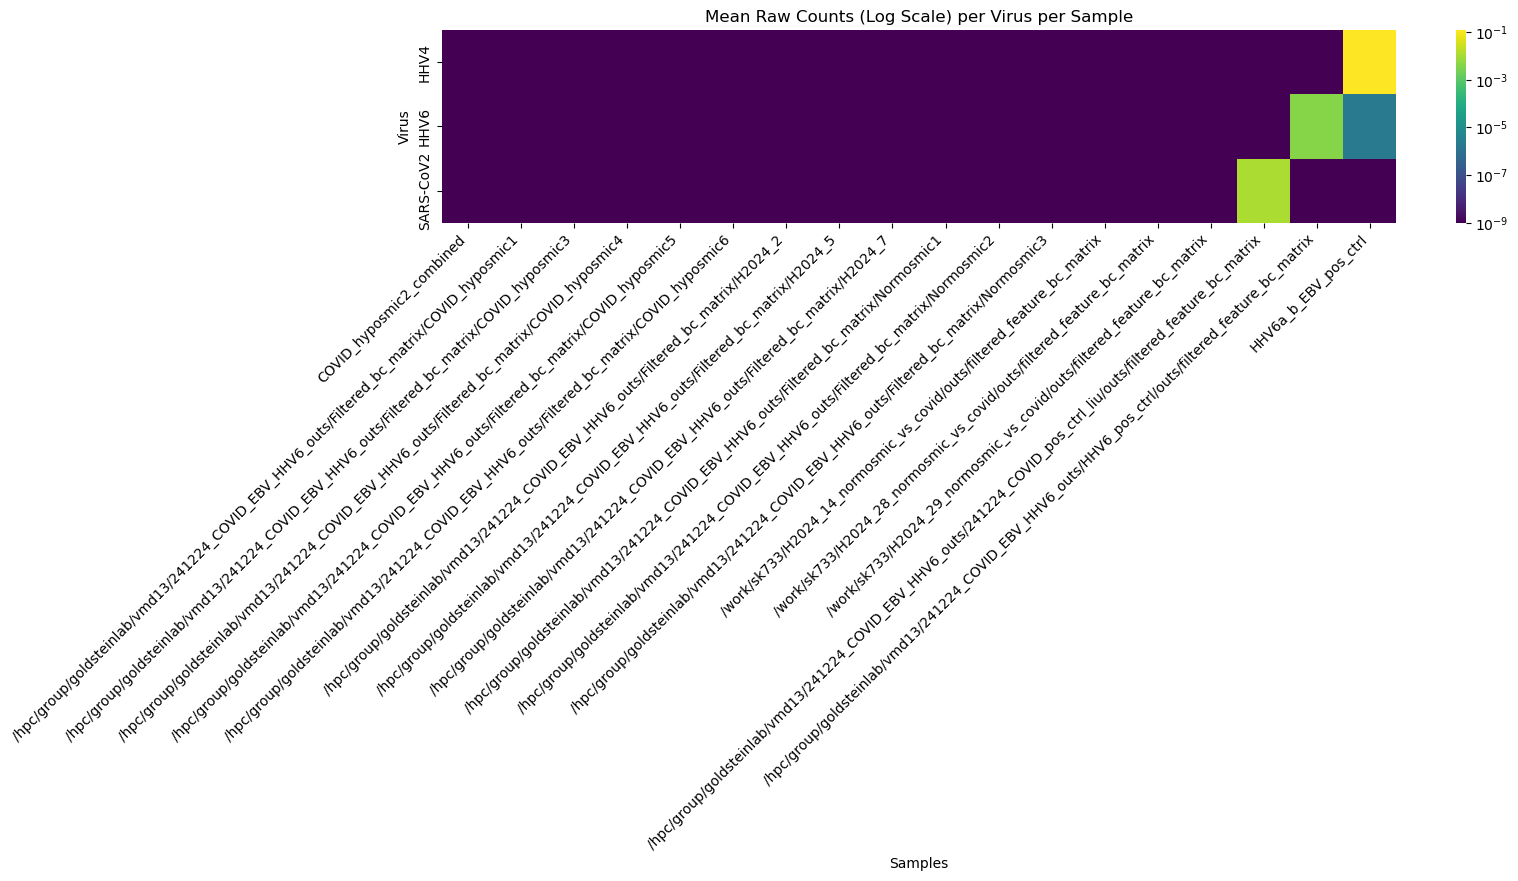

In [7]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import numpy as np
import pandas as pd

# ... your existing code above that builds df_grouped ...

##############################################################################
# D) PLOT HEATMAP WITH CUSTOM ORDER, TRANSPOSE, AND LOG SCALE
##############################################################################

# 1. Define desired sample order so "HHV6a_b_EBV_pos_ctrl" is on the far right
desired_order = [b for b in df_grouped.index if b != "HHV6a_b_EBV_pos_ctrl"]
desired_order.append("HHV6a_b_EBV_pos_ctrl")

df_grouped_reordered = df_grouped.loc[desired_order, :]

# 2. Transpose so that columns = samples (x‑axis) and rows = viruses (y‑axis)
df_plot = df_grouped_reordered.T

# 3. Replace zeros with a small value for LogNorm
df_plot_no0 = df_plot.replace(0, 1e-9)

# 4. Determine vmin/vmax
vmin = 1e-9
vmax = df_plot_no0.values.max()

plt.figure(figsize=(1 + 0.8 * df_plot_no0.shape[1], 1 + 0.5 * df_plot_no0.shape[0]))

sns.heatmap(
    df_plot_no0,
    cmap="viridis",
    norm=mcolors.LogNorm(vmin=vmin, vmax=vmax),
    xticklabels=True,
    yticklabels=True
)

plt.xticks(rotation=45, ha="right")
plt.xlabel("Samples")
plt.ylabel("Virus")
plt.title("Mean Raw Counts (Log Scale) per Virus per Sample")
plt.tight_layout()

# Save as SVG
plt.savefig("250225_horiz_simple_virus_heatmap.svg", format="svg", dpi=300, bbox_inches='tight')

# Show on screen
plt.show()


/tmp/ipykernel_2539389/2817498298.py:69: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


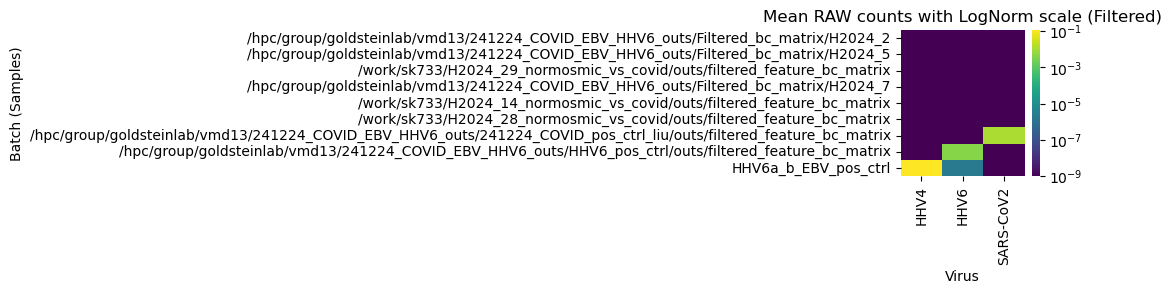

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# The original custom row order
custom_row_order = [
    '/hpc/group/goldsteinlab/vmd13/241224_COVID_EBV_HHV6_outs/Filtered_bc_matrix/COVID_hyposmic1',
    'COVID_hyposmic2_combined',
    '/hpc/group/goldsteinlab/vmd13/241224_COVID_EBV_HHV6_outs/Filtered_bc_matrix/COVID_hyposmic3',
    '/hpc/group/goldsteinlab/vmd13/241224_COVID_EBV_HHV6_outs/Filtered_bc_matrix/COVID_hyposmic4',
    '/hpc/group/goldsteinlab/vmd13/241224_COVID_EBV_HHV6_outs/Filtered_bc_matrix/COVID_hyposmic5',
    '/hpc/group/goldsteinlab/vmd13/241224_COVID_EBV_HHV6_outs/Filtered_bc_matrix/COVID_hyposmic6',
    '/hpc/group/goldsteinlab/vmd13/241224_COVID_EBV_HHV6_outs/Filtered_bc_matrix/H2024_2',
    '/hpc/group/goldsteinlab/vmd13/241224_COVID_EBV_HHV6_outs/Filtered_bc_matrix/H2024_5',
    '/work/sk733/H2024_29_normosmic_vs_covid/outs/filtered_feature_bc_matrix',
    '/hpc/group/goldsteinlab/vmd13/241224_COVID_EBV_HHV6_outs/Filtered_bc_matrix/Normosmic1',
    '/hpc/group/goldsteinlab/vmd13/241224_COVID_EBV_HHV6_outs/Filtered_bc_matrix/Normosmic2',
    '/hpc/group/goldsteinlab/vmd13/241224_COVID_EBV_HHV6_outs/Filtered_bc_matrix/Normosmic3',
    '/hpc/group/goldsteinlab/vmd13/241224_COVID_EBV_HHV6_outs/Filtered_bc_matrix/H2024_7',
    '/work/sk733/H2024_14_normosmic_vs_covid/outs/filtered_feature_bc_matrix',
    '/work/sk733/H2024_28_normosmic_vs_covid/outs/filtered_feature_bc_matrix',
    '/hpc/group/goldsteinlab/vmd13/241224_COVID_EBV_HHV6_outs/241224_COVID_pos_ctrl_liu/outs/filtered_feature_bc_matrix',
    '/hpc/group/goldsteinlab/vmd13/241224_COVID_EBV_HHV6_outs/HHV6_pos_ctrl/outs/filtered_feature_bc_matrix',
    'HHV6a_b_EBV_pos_ctrl'
]

# Define the samples you want to remove
samples_to_remove = [
    '/hpc/group/goldsteinlab/vmd13/241224_COVID_EBV_HHV6_outs/Filtered_bc_matrix/COVID_hyposmic1',
    'COVID_hyposmic2_combined',
    '/hpc/group/goldsteinlab/vmd13/241224_COVID_EBV_HHV6_outs/Filtered_bc_matrix/COVID_hyposmic3',
    '/hpc/group/goldsteinlab/vmd13/241224_COVID_EBV_HHV6_outs/Filtered_bc_matrix/COVID_hyposmic4',
    '/hpc/group/goldsteinlab/vmd13/241224_COVID_EBV_HHV6_outs/Filtered_bc_matrix/COVID_hyposmic5',
    '/hpc/group/goldsteinlab/vmd13/241224_COVID_EBV_HHV6_outs/Filtered_bc_matrix/COVID_hyposmic6',
    '/hpc/group/goldsteinlab/vmd13/241224_COVID_EBV_HHV6_outs/Filtered_bc_matrix/Normosmic1',
    '/hpc/group/goldsteinlab/vmd13/241224_COVID_EBV_HHV6_outs/Filtered_bc_matrix/Normosmic2',
    '/hpc/group/goldsteinlab/vmd13/241224_COVID_EBV_HHV6_outs/Filtered_bc_matrix/Normosmic3'
]

# Filter out the samples_to_remove
custom_row_order_filtered = [
    sample for sample in custom_row_order
    if sample not in samples_to_remove
]

# Define the custom column order as before
custom_column_order = ["HHV4", "HHV6", "SARS-CoV2"]

# Now subset your DataFrame using the filtered row order
df_custom = df_grouped.loc[custom_row_order_filtered, custom_column_order]

# Replace zeros with a small value for LogNorm
df_custom_no0 = df_custom.replace(0, 1e-9)

vmin = 1e-9  
vmax = df_custom_no0.values.max()  # or pick something appropriate

plt.figure(figsize=(0.5 + 0.5 * df_custom_no0.shape[1], 1 + 0.1 * df_custom_no0.shape[0]))
sns.heatmap(
    df_custom_no0,
    cmap="viridis",
    norm=LogNorm(vmin=vmin, vmax=vmax),
    xticklabels=True,
    yticklabels=True
)
plt.xlabel("Virus")
plt.ylabel("Batch (Samples)")
plt.title("Mean RAW counts with LogNorm scale (Filtered)")
plt.tight_layout()

# Save the figure (example: PDF)
plt.savefig("/hpc/group/goldsteinlab/vmd13/250219_simple_heatmap_filtered2.svg", bbox_inches="tight")

plt.show()
